Cumulative variance explained by 50 components: 0.64


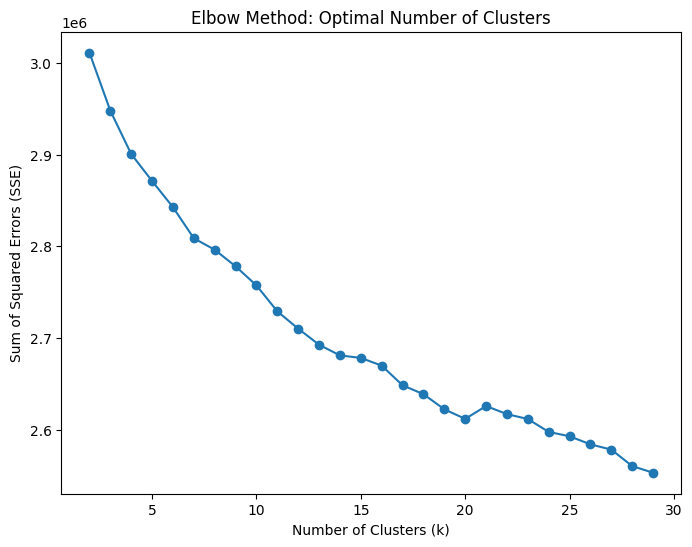

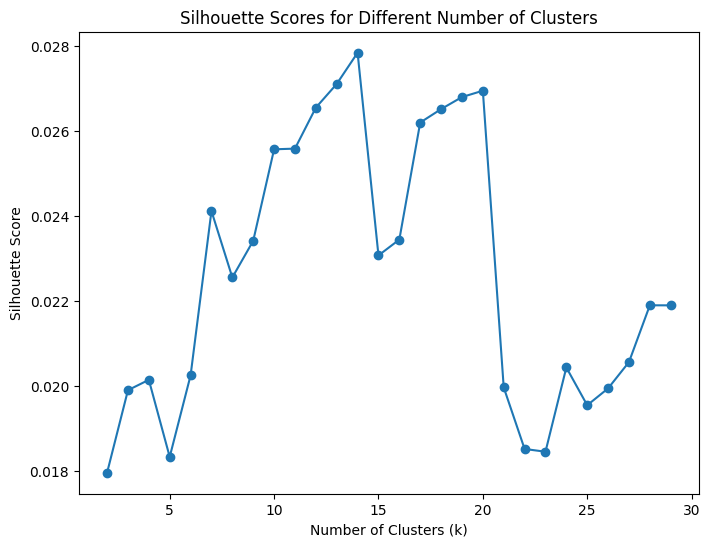

Cluster sizes:
2     111
10     85
6      84
4      83
12     81
8      76
9      71
3      67
5      63
0      61
13     55
14     52
1      43
11     39
7      29
Name: count, dtype: int64
Number of clusters found by DBSCAN: 0


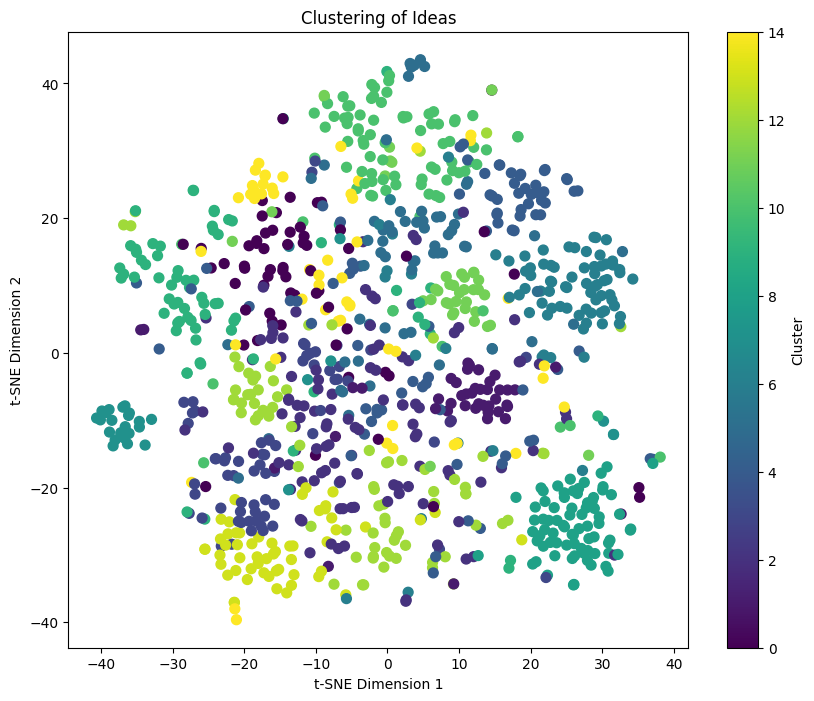


Cluster 0 contains 61 ideas.
Top Categories:
Enhancement             45
Quick Win                4
New Feature Concept      4
System Configuration     3
App Specific             2
Name: count, dtype: int64

Top Statuses:
New Submission           48
Implemented               9
Not Currently Planned     2
Closed as Other           2
Name: count, dtype: int64

Sample Titles:
['Scorecards to be accesssible for those who are visually impaired (508)', 'Country Type Question', 'Enable Dependent Questions in Development Field Questions', 'Judging Tool -3 column with idea details visible', 'Disclaimer on max minutes allowed for Session Time Out Minutes field']

Cluster 1 contains 43 ideas.
Top Categories:
Enhancement             26
Whiteboard               5
Quick Win                5
New Feature Concept      3
System Configuration     2
Name: count, dtype: int64

Top Statuses:
New Submission           36
Implemented               4
Not Currently Planned     2
Closed as Other           1
Name:

In [15]:
# Import necessary libraries
import os
import json
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pinecone.grpc import PineconeGRPC as Pinecone

# Load environment variables
load_dotenv()

# Set up Pinecone API key and initialize
pinecone_api_key = os.getenv("PINECONE_API_KEY")
if not pinecone_api_key:
    raise ValueError("PINECONE_API_KEY is not set in the .env file")

pc = Pinecone(api_key=pinecone_api_key)

index_name = 'idea-index'
namespace = os.getenv("PINECONE_NAMESPACE")
index = pc.Index(index_name)

# Use the describe_index_stats method to get metadata including total vectors
stats = index.describe_index_stats()
vector_count = stats["total_vector_count"]

all_ids = []

for ids in index.list(namespace=namespace):
    all_ids.extend(ids)

embeddings = []

# Step 1: Fetch embeddings in batches
batch_size = 500

for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    # Extract only the "values" from each vector
    embeddings.extend([vector["values"] for vector in response["vectors"].values()])

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings, dtype=np.float32)  # Ensure data type consistency

# Step 2: Dimensionality reduction
# First, scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Use PCA for initial reduction to 50 dimensions
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Check variance explained by PCA components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative variance explained by 50 components: {explained_variance:.2f}")

# Use t-SNE for final 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Step 3: Determine optimal number of clusters using Elbow Method
sse = []  # Sum of Squared Errors
k_values = range(2, 30)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_embeddings)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.title("Elbow Method: Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.show()

# Step 4: Determine optimal clusters using Silhouette Score
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_embeddings)
    score = silhouette_score(scaled_embeddings, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Step 5: Use K-Means clustering with the chosen number of clusters
num_clusters = 15  # Replace with your chosen number based on the methods above
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_embeddings)

# Analyze cluster sizes
cluster_sizes = pd.Series(labels).value_counts()
print(f"Cluster sizes:\n{cluster_sizes}")

# Step 6: Use DBSCAN for density-based clustering (optional)
dbscan = DBSCAN(eps=5, min_samples=3)  # Increase `eps` and reduce `min_samples`
db_labels = dbscan.fit_predict(scaled_embeddings)
num_dbscan_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print(f"Number of clusters found by DBSCAN: {num_dbscan_clusters}")

# Step 7: Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")
plt.title("Clustering of Ideas")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 8: Fetch metadata from Pinecone and group by cluster
metadata_dict = {}

# Fetch metadata for all IDs in batches
for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    for vector_id, vector_data in response['vectors'].items():
        metadata_dict[vector_id] = vector_data['metadata']

# Group metadata by cluster
cluster_metadata = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(labels):
    vector_id = all_ids[idx]
    if vector_id in metadata_dict:  # Ensure metadata exists for this ID
        cluster_metadata[label].append(metadata_dict[vector_id])

# Display a summary of themes within each cluster
for cluster_id, metadata_list in cluster_metadata.items():
    print(f"\nCluster {cluster_id} contains {len(metadata_list)} ideas.")
    
    # Extract metadata fields for analysis
    categories = [meta['category'] for meta in metadata_list if 'category' in meta and meta['category']]
    statuses = [meta['status'] for meta in metadata_list if 'status' in meta and meta['status']]
    submitters = [meta['submitter'] for meta in metadata_list if 'submitter' in meta and meta['submitter']]
    
    # Count occurrences of categories and statuses
    category_counts = pd.Series(categories).value_counts()
    status_counts = pd.Series(statuses).value_counts()
    
    print("Top Categories:")
    print(category_counts.head(5))  # Display top 5 categories
    print("\nTop Statuses:")
    print(status_counts.head(5))  # Display top 5 statuses
    print("\nSample Titles:")
    print([meta['title'] for meta in metadata_list[:5] if 'title' in meta])  # Display a few sample titles

# Combine all metadata for each cluster
cluster_data = {}
for cluster_id, metadata_list in cluster_metadata.items():
    cluster_data[cluster_id] = metadata_list

# Save cluster data as JSON
with open("cluster_data.json", "w") as json_file:
    json.dump(cluster_data, json_file, indent=4)

# Optionally save each cluster to separate CSV files
for cluster_id, metadata_list in cluster_metadata.items():
    df = pd.DataFrame(metadata_list)  # Convert metadata to DataFrame
    df.to_csv(f"cluster_{cluster_id}.csv", index=False)
    print(f"Cluster {cluster_id} saved to cluster_{cluster_id}.csv")